# Unsupervised Learning: Galaxy10 Tutorial

In [1]:
# Import base python libraries
import math
import random
import sys

# Import the necessary array-handling libraries
import h5py
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.io import loadmat
from scipy.spatial import distance

# Import additional NN training modules
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM

# Import Pytorch for neural network training
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define colors for plotting
blue = np.array([0.5,0.6,0.8])
red = np.array([0.8,0.5,0.4])
purple = np.array([0.84,0.71,0.95])

## Problem Statement:

The Sloan Digital Sky Survey (SDSS) is an ongoing astronomical imaging survey conducted by the Apache Point Observatory in Sunspot, New Mexico. Since 2000, the project has incrementally released photometric images covering nearly 15,000 square degrees of the night sky, with over one million celestial objects identified for detailed stereoscopic processing. 

In this tutorial, we will work with a subset of SDSS images, each of which depicts a small section of sky. Our goal is to identify common features among the images such that each snapshot may be assigned to a group (or cluster) with similar features. 

The identification of groups is a common first step when processing large scientific datasets. However, keep in mind that we enforce no expectation on the number or nature of these groups (i.e., we do not assign labels to the images beforehand). Instead, our goal is to find natural groups in an unsupervised manner, based solely on the structure of the data. 


## Part 0: Normalize the data

We will begin by normalizing our data, such that each entry has a magnitude lying between 0 and 1, and such that the dataset is centered about the origin.

In [2]:
# Copy images to a folder accessible by the GPU
! mkdir /tmp/data
! cp -r /scratch1/10386/lsmith9003/share/tutorialData/galaxy10/Galaxy10_DECals.h5 /tmp/data/.

# Load images and labels from the Galaxy 10 file 
# (note that we are downsampling slightly to make the dataset more manageable for demonstration)
with h5py.File('/tmp/data/Galaxy10_DECals.h5','r') as File:
    labels = np.array(File['ans'])
    indSub = np.where((labels==2) | (labels==8))
    images = np.array(File['images'])[indSub]
    labels = labels[indSub]
    
# Organize the set of images into a data matrix
chTot = int(3)
ySize = int(256)
xSize = int(256)
X = np.reshape(images,newshape=(len(images),chTot*ySize*xSize))

# Normalize the dataset 
X = X/255.
X = X - np.mean(X,axis=0)

# Display the shape of our data matrix
print(np.shape(X))


mkdir: cannot create directory '/tmp/data': File exists


/tmp/ipykernel_14841/3929708727.py:17: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  X = np.reshape(images,newshape=(len(images),chTot*ySize*xSize))


(4068, 196608)


Let's display one of the images from our dataset, just to give us a sense of the information contained within each entry.

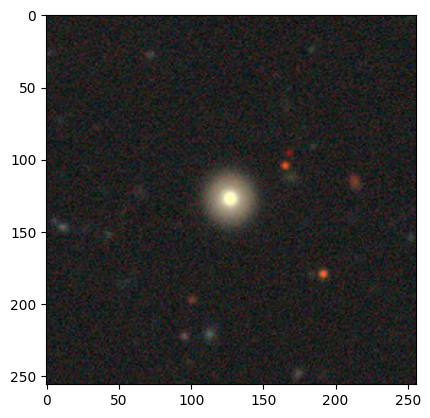

In [3]:
# Select a random image from the dataset to display as an example
displayImage = np.squeeze(images[random.randint(0,len(X))])
fig0 = plt.figure()
plt.imshow(displayImage)
plt.show()

## Part 1: Perform PCA on the data

We will now find a useful representation of our data using principal component analysis (PCA). The idea is that, because PCA captures data variances in an optimal way, this technique will provide a way of visually identifying any large clusters in our data, if present.

In [4]:
# Define the number of PCA modes to retain
numPCA = int(500)

# Initialize a PCA object (note that we select the 'auto' option for the SVD solver. The 'auto'
# option selects a PCA strategy based on the shape of the input data. For our dataset, which has
# far more features than samples, the 'auto' option will correspond to a randomized SVD strategy.)
pca = PCA(n_components=numPCA, svd_solver='auto')

# Perform PCA on the data matrix
pca.fit(X)
A = pca.transform(X)

From PCA alone, we can obtain quite a bit of information regarding our dataset. For example, let us see how well we are able to capture the data variance as a function of how many principal components are retained.

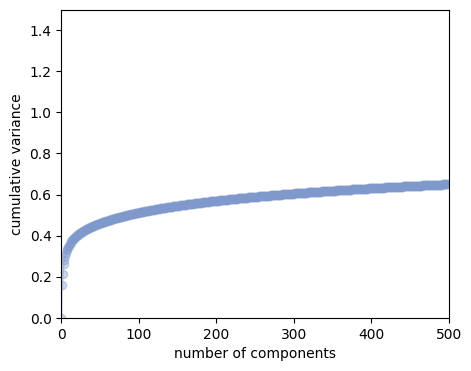

In [5]:
# Display the amount of variance explained by each principal direction
sigma = pca.explained_variance_ratio_
sigmaCumulative = np.zeros((np.shape(sigma)))
for ind in range(0,len(sigma)):
	sigmaCumulative[ind] = np.sum(sigma[0:ind])

# Figure 1: plot the cumulative energy associated with the n leading principal components    
fig1 = plt.figure(figsize=(5,4))
ax1 = fig1.add_subplot()
plt.plot(np.arange(0,numPCA,1),sigmaCumulative,marker='o',color=[0.5,0.6,0.8],alpha=0.4)
plt.xlabel('number of components')
plt.ylabel('cumulative variance')
ax1.set_xlim(0,numPCA)
ax1.set_ylim(0,1.5)
plt.show()

We see that our dataset is actually quite complex: it requires more than 500 components to recover 70% of the data variance. However, keep in mind that our original dataset consists of 256 x 256 x 3 = 196608 dimensions. A reduction to ~1000 dimensions is actually quite a substantial improvement!

## Part 2: Perform K-means clustering

Our goal now is to use the low-dimensional representation of the dataset as the basis for clustering analysis. Let's begin by simply viewing the leading three principal components, which should give us some basic intuition for how the data is naturally grouped. Note that this step is included for development/visualization purposes only (a typical unsupervised workflow does not necessarily involve the user's visual analysis of the dataset).


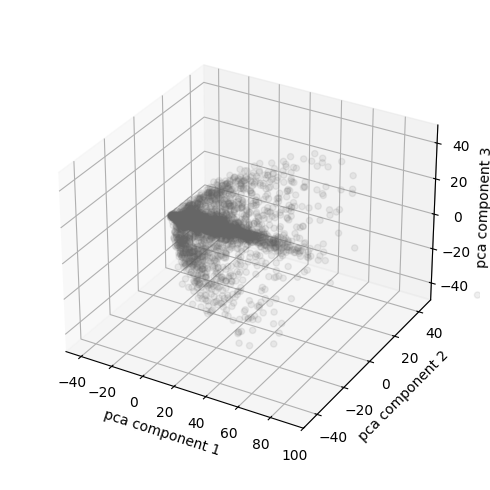

In [6]:
# Figure 2: PCA Components in black and white
fig2 = plt.figure(figsize=(6.5,5))
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(A[:,0],A[:,1],A[:,2],marker='o',color=(0.4,0.4,0.4),alpha=0.1)
ax2.set_xlabel('pca component 1', fontsize=10, rotation = 0)
ax2.set_ylabel('pca component 2', fontsize=10, rotation = 0)
ax2.set_zlabel('pca component 3', fontsize=10, rotation = 0)
ax2.set_xlim(-50,100)
ax2.set_ylim(-50,50)
ax2.set_zlim(-50,50)
plt.tight_layout()
ax2.set_box_aspect(aspect=None, zoom=0.9)
plt.show()

Visually, we see that the data is grouped into roughly two structures: the first is stretched along the first principal component, while the second fans out in a sort of paraboloid. 

Now, we wish to perform a clustering analysis on this dataset. We will begin by performing k-means clustering, with a user input of n_clusters=2, in the space defined by the leading 3 PCA components. Note that in practice, we generally determine the required number of clusters by evaluating some performance criterion, such as the Bayesian Information Criterion (BIC). However, we are primarily interested in obtaining basic intuition for these methods, so n_clusters=2 will be sufficient for this demonstration.


In [7]:
# Perform kmeans clustering on the first two components of the dataset
kmeans = KMeans(n_clusters=2).fit(A[:,range(0,3)])
kcen = kmeans.cluster_centers_
klabels = kmeans.labels_

# Extract the coordinates corresponding to each of the three clusters
kind0 = np.where(klabels==0)
kind1 = np.where(klabels==1)


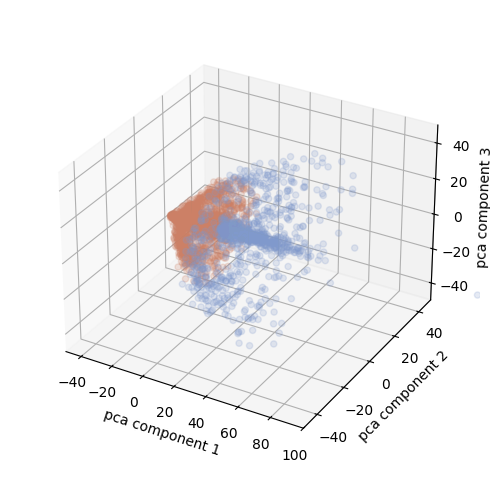

In [8]:
# Figure 3: PCA Components with clusters identified by Kmeans
fig3 = plt.figure(figsize=(6.5,5))
ax3 = fig3.add_subplot(projection='3d')
ax3.scatter(A[kind0,0],A[kind0,1],A[kind0,2],marker='o',color=blue,alpha=0.2)
ax3.scatter(A[kind1,0],A[kind1,1],A[kind1,2],marker='o',color=red,alpha=0.2)
ax3.set_xlabel('pca component 1', fontsize=10, rotation = 0)
ax3.set_ylabel('pca component 2', fontsize=10, rotation = 0)
ax3.set_zlabel('pca component 3', fontsize=10, rotation = 0)
ax3.set_xlim(-50,100)
ax3.set_ylim(-50,50)
ax3.set_zlim(-50,50)
ax3.set_box_aspect(aspect=None, zoom=0.9)
plt.tight_layout()
plt.show()


Question: do the identified clusters match with your visual intuition? Why or why not? When answering this question, recall the assumptions inherent to the K-means clustering algorithm, particularly in regards to the cluster shape.

## Part 3: Build a Gaussian Mixture Model

Let's examine the possibility of using a different clustering algorithm. Specifically, we'll draw from the probablistic side of unsupervised learning and design a Gaussian Mixture Model (GMM) to represent the distributon of data along the first two principal components. Recall that a GMM models the distribution of data as a superposition of Gaussians. From a clustering perspective, the main advantage of a GMM is that it allows for cluster shapes more complicated than a simple circle or sphere.

We'll start by visualizing our GMM in two dimensions. This will give us a better idea of how a GMM works, prior to using it for clustering prediction.

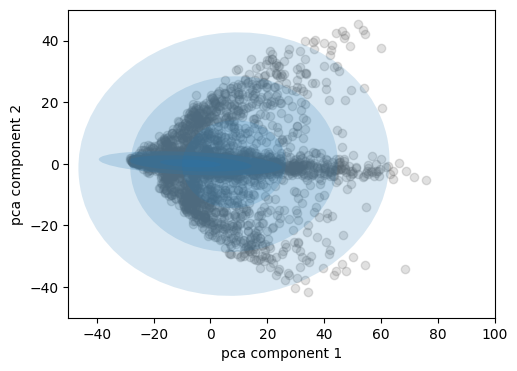

In [9]:
# Construct a Gaussian mixture model based on the first two components of the dataset
gmm = GMM(n_components=2, covariance_type='full').fit(A[:,range(0,2)])

# Define a function for visualizing the components of the GMM
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    elif covariance.shape == ():
        angle = 0
        width = height = 2 * np.sqrt(covariance)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        Ellipse(xy=position, width=nsig * width, height=nsig * height, angle=angle, **kwargs)
        ax.add_patch(Ellipse(xy=position, width=nsig * width, height=nsig * height,
                            angle=angle, **kwargs))

# Figure 4: PCA Components with GMM distributions
fig4 = plt.figure(figsize=(5.5,4))
ax4 = fig4.add_subplot()
ax4.scatter(A[:,0],A[:,1],marker='o',color=(0.4,0.4,0.4),alpha=0.2)
w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
	draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax4)
ax4.set_xlim(-50,100)
ax4.set_ylim(-50,50)
ax4.set_xlabel('pca component 1', fontsize=10)
ax4.set_ylabel('pca component 2', fontsize=10)
plt.show()

We see that the GMM has two components to its distribution: the first is stretched along the first principal direction, while the second features a large standard deviation and expands around the dataset. Let's see how this distribution clusters the data, based on the likelihood of each point.

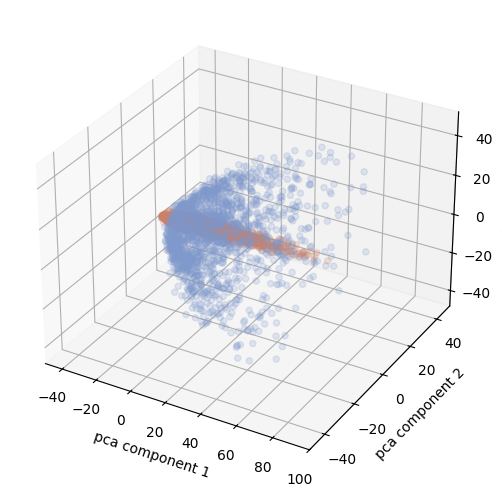

In [10]:
# Predict clusters based on the GMM distribution
gmm = GMM(n_components=2, covariance_type='full').fit(A[:,range(0,3)])
glabels = gmm.predict(A[:,range(0,3)])

# Extract coordinates of each cluster
gind0 = np.where(glabels==0)
gind1 = np.where(glabels==1)
gind0 = gind0[0]
gind1 = gind1[0]

# Plot the dataset with GMM clusters labeled
fig5 = plt.figure(figsize=(6.5,5))
ax5 = fig5.add_subplot(projection='3d')
ax5.scatter(A[gind0,0],A[gind0,1],A[gind0,2],marker='o',color=blue,alpha=0.2)
ax5.scatter(A[gind1,0],A[gind1,1],A[gind1,2],marker='o',color=red,alpha=0.2)
ax5.set_xlabel('pca component 1', fontsize=10, rotation = 0)
ax5.set_ylabel('pca component 2', fontsize=10, rotation = 0)
ax5.set_zlabel('pca component 3', fontsize=10, rotation = 0)
ax5.set_xlim(-50,100)
ax5.set_ylim(-50,50)
ax3.set_zlim(-50,50)
ax3.set_box_aspect(aspect=None, zoom=0.9)
plt.tight_layout()
plt.show()

Compared to the k-means algorithm, how well do our GMM clusters capture the natural distribution of the dataset? What features of a GMM might make it a better or worse choice for our data?

We can further assess our clustering algorithm by considering what each cluster represents in the original image space. Let us select a random data point from cluster 0 (blue) and a random data point from cluster 1 (red) and display the corresponding images in reconstructed RGB space. This will allow us to express the difference between the two clusters in the language of the original SDSS images.

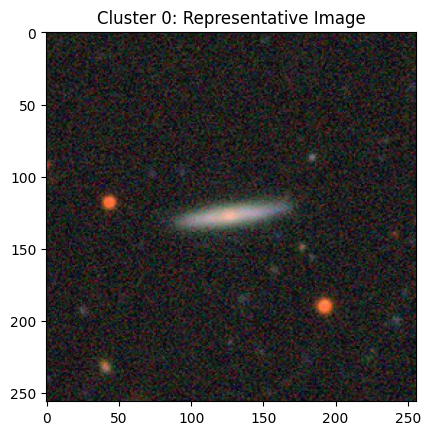

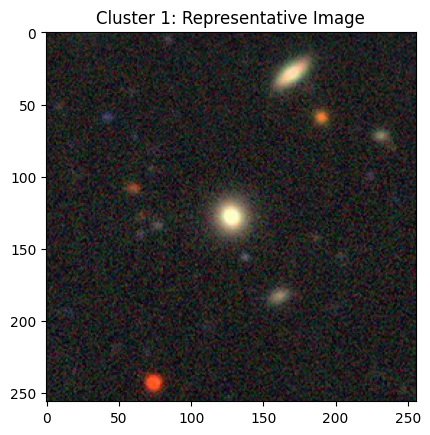

In [11]:
# Select a random index from our two clusters
random.shuffle(gind0)
random.shuffle(gind1)
displayImage0 = np.squeeze(images[gind0[0]])
displayImage1 = np.squeeze(images[gind1[0]])

# Display image for cluster 0
fig6 = plt.figure()
plt.imshow(displayImage0)
plt.title('Cluster 0: Representative Image')
plt.show()

# Display image for cluster 1
fig7 = plt.figure()
plt.imshow(displayImage1)
plt.title('Cluster 1: Representative Image')
plt.show()

What is the main difference between the image in cluster 0 and the image in cluster 1? That is, what has the algorithm "learned" about the types of images in the dataset? If the images appear too similar, try re-running the code one or two more times.

## Part 4: Evaluate the results of a deep learning approach (autoencoder)

We will also consider how deep learning can be leveraged to augment our understanding of this dataset. Prior to this tutorial, we trained a variational autoencoder based on a subset of images from the Galaxy10 dataset. This autoencoder consists of several interconnected CNN's and MLP, with a bottleneck dimension of 128, and a nonlinear activation function. We define the autoencoder architecture in PyTorch below, such that it can be loaded into the workspace and compared to classical unsupervised methods:

In [12]:
# Define the encoder architecture
class Encoder(nn.Module):
	def __init__(self):
		super().__init__()

		# Convolution/pooling layers
		self.numCh = int(32)
		self.conv1 = nn.Conv2d(in_channels=3,out_channels=self.numCh,kernel_size=3,padding='same')
		self.conv2 = nn.Conv2d(in_channels=self.numCh,out_channels=self.numCh,kernel_size=3,padding='same')
		self.pool = nn.MaxPool2d(2,2)

		# MLP layers
		self.mlp1 = nn.Linear(self.numCh*16*16,1024)
		self.mlp2 = nn.Linear(1024,256)

	def forward(self,x):

		# Convolution/pooling layers
		x = self.pool(F.tanh(self.conv1(x))) 
		x = self.pool(F.tanh(self.conv2(x))) 

		# Flatten the 2D inputs (all dimensions but batch)
		x = torch.flatten(x, 1)

		# MLP/fully-connected layers
		x = F.tanh(self.mlp1(x))
		x = F.tanh(self.mlp2(x))

		# Extract the mean and standard deviation associated with each direction
		mu = x[:,0:128]
		logvar = x[:,128:]

		# Define the latent space based on a random sample
		xLat = mu + torch.randn(mu.shape)*torch.exp(0.50*logvar)

		# Return the final output of the network
		return xLat, mu, logvar


# Define the decoder architecture
class Decoder(nn.Module):
	def __init__(self):
		super().__init__()	

		# Scaling parameter
		self.scale = nn.Parameter(torch.diag(torch.rand((1,))))

		# Convolution/pooling layers
		self.numCh = int(32)
		self.conv1 = nn.Conv2d(in_channels=self.numCh,out_channels=self.numCh,kernel_size=3,padding='same') # 128
		self.conv2 = nn.Conv2d(in_channels=self.numCh,out_channels=3,kernel_size=3,padding='same') # 64
		self.upsample = nn.Upsample(scale_factor=2)

		# MLP layers
		self.mlp1 = nn.Linear(128,256)
		self.mlp2 = nn.Linear(256,1024)
		self.mlp3 = nn.Linear(1024,self.numCh*16*16)

	def forward(self,x):

		# Batch size
		batchSize = x.size()[0]

		# MLP/fully-connected layers
		x = F.tanh(self.mlp1(x))
		x = F.tanh(self.mlp2(x))
		x = F.tanh(self.mlp3(x))

		# Flatten the 2D inputs (all dimensions but batch)
		x = torch.reshape(x, shape=(batchSize,self.numCh,16,16))

		# Convolution/pooling layers
		x = self.upsample(F.tanh(self.conv1(x)))
		x = self.upsample(F.tanh(self.conv2(x)))

		# Return the final output of the network
		return x


As a starting point, let's load in a test image at random and see how well the autoencoder is able to reconstruct its main features.


In [13]:
# Define the number of channels associated with each image
chTot = int(3)

# Load images and labels from the Galaxy 10 file 
with h5py.File('/tmp/data/Galaxy10_DECals.h5','r') as File:
    labels = np.array(File['ans'])
    indSub = np.where((labels==2) | (labels==8))
    yInput = np.array(File['images'])[indSub]

# Downsample inputs (if necessary)
yInput = yInput[:,96:160,96:160,:]
yInput = yInput[0::]/255

# Subtract mean 
yMean = np.reshape(np.mean(yInput,axis=0),newshape=(1,64,64,3))
for ind in range(0,len(yInput[:,0,0,0])):
	yInput[ind,:,:,:] = yInput[ind,:,:,:] - yMean

# Re-adjust the shape of the inputs for convolution layers
yInput = np.transpose(yInput,[0,3,1,2])

# Instantiate the encoder and decoder
encoder = Encoder()
decoder = Decoder()

# Load the appropriate weights
! mkdir /tmp/models
! cp -r /scratch1/10386/lsmith9003/share/tutorialModels/galaxy10/encoder.pth /tmp/models/.
! cp -r /scratch1/10386/lsmith9003/share/tutorialModels/galaxy10/decoder.pth /tmp/models/.
if torch.cuda.is_available():
    device = torch.device("cuda")          
    print("GPU is available. Using CUDA.")
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")
encoder.load_state_dict(torch.load('/tmp/models/encoder.pth',weights_only=True,map_location=torch.device(device)))
decoder.load_state_dict(torch.load('/tmp/models/decoder.pth',weights_only=True,map_location=torch.device(device)))

/tmp/ipykernel_14841/1996744387.py:15: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  yMean = np.reshape(np.mean(yInput,axis=0),newshape=(1,64,64,3))


mkdir: cannot create directory '/tmp/models': File exists
GPU is available. Using CUDA.


<All keys matched successfully>

/tmp/ipykernel_14841/2965069577.py:3: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  yEval = np.reshape(yInput[indRand],newshape=(1,3,64,64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04705882398333974..1.0000000126252597].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.20063804221830436..1.0484436803405057].


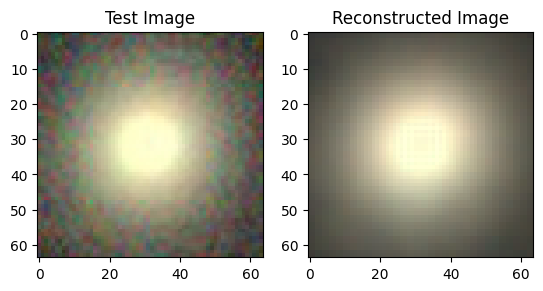

In [14]:
# Select one random test image for autoencoder evaluation
indRand = np.random.choice(int(len(yInput)))
yEval = np.reshape(yInput[indRand],newshape=(1,3,64,64))

# Evaluate the neural network
yEval = torch.tensor(yEval,dtype=torch.float32)
yLat, mu, logvar = encoder(yEval)
yPred = decoder(yLat)

# Display the predicted test and train images
fig6 = plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.transpose(yEval[0].detach().numpy(),[1,2,0])+np.squeeze(yMean))
plt.title('Test Image')
plt.subplot(1,2,2)
plt.imshow(np.transpose(yPred[0].detach().numpy(),[1,2,0])+np.squeeze(yMean))
plt.title('Reconstructed Image')
plt.show()

Run the segment above several times. Based on your observation, what features of the input image has the autoencoder learned? What features of the original image is it unable to reconstruct?

At this stage, let us recall that an autoencoder offers two primary benefits compared to traditional unsupervised learning techniques. The first is its latent space, which allows for nonlinear partitioning of the data. Let's have a look at the latent space associated with our training data. Note that our latent space is too large (128 variables) to examine on one plot, so we will perform some basic re-scaling and examine the first two dimensions.

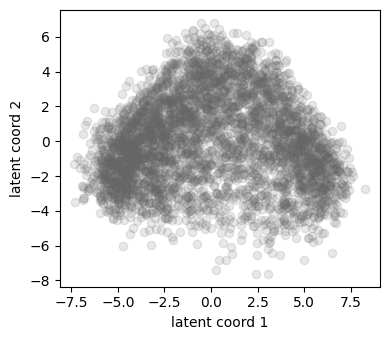

In [15]:
# Evaluate the encoder for all images (this allows us to examine the latent distribution)
yLat, mu, logvar = encoder(torch.tensor(yInput,dtype=torch.float32))
yLat = yLat.detach().numpy()

# Re-order latent directions for visualization purposes
pca = PCA(n_components=3,svd_solver='auto')
pca.fit(yLat)
yLatPlot = pca.transform(yLat)

# Figure 7: plot  the latent space
fig7 = plt.figure(figsize=(4,3.5))
ax7 = fig7.add_subplot()
ax7.scatter(yLatPlot[:,0],yLatPlot[:,1],marker='o',color=(0.4,0.4,0.4),alpha=0.15)
ax7.set_xlabel('latent coord 1', fontsize=10)
ax7.set_ylabel('latent coord 2', fontsize=10)
plt.tight_layout()
plt.show()

The autoencoder appears to represent the data as a 'U' shape. We can think about this shape as consisting of two clusters that meet to form the center of the 'U'. Let us explore what each of the two clusters in the original image space.

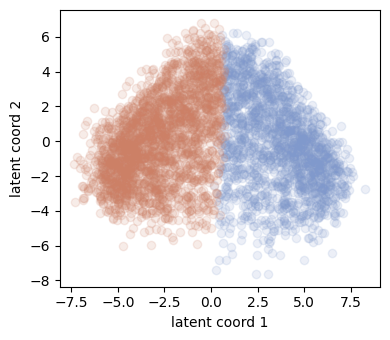

(4068, 128)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11516055086204102..1.1008054217351997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11152648856232761..1.0018816602671146].


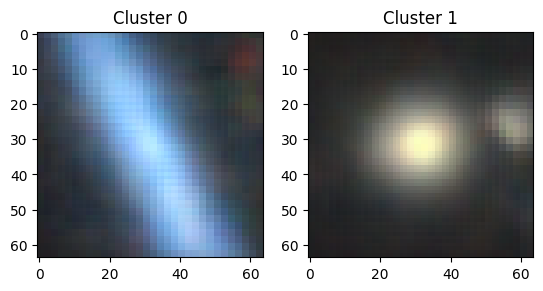

In [16]:
# Perform kmeans clustering on the first two components of the dataset
kmeans = KMeans(n_clusters=2).fit(yLat)
kcen = kmeans.cluster_centers_
klabels = kmeans.labels_

# Extract the coordinates corresponding to each of the three clusters
kind0 = np.where(klabels==0)
kind1 = np.where(klabels==1)
kind0 = kind0[0]
kind1 = kind1[0]

# Find coordinates of points closest to cluster centers
kindPlot0 = np.argmin((yLatPlot[kind0,0] - kcen[0,0])**2 + (yLatPlot[kind0,1] - kcen[0,1])**2)
kindPlot1 = np.argmin((yLatPlot[kind1,0] - kcen[1,0])**2 + (yLatPlot[kind1,1] - kcen[1,1])**2)

# Figure 8: plot the latent space with data points colored by cluster ID
fig8 = plt.figure(figsize=(4,3.5))
ax8 = fig8.add_subplot()
ax8.scatter(yLatPlot[kind0,0],yLatPlot[kind0,1],marker='o',color=blue,alpha=0.15)
ax8.scatter(yLatPlot[kind1,0],yLatPlot[kind1,1],marker='o',color=red,alpha=0.15)
ax8.set_xlabel('latent coord 1', fontsize=10)
ax8.set_ylabel('latent coord 2', fontsize=10)
plt.tight_layout()
plt.show()

# Figure 9: plot a representative image from each cluster
fig9 = plt.figure()
plt.subplot(1,2,1)
print(np.shape(yLat))
yEval = decoder(torch.tensor(yLat,dtype=torch.float32))
yEval = yEval.detach().numpy()
random.shuffle(kind0)
random.shuffle(kind1)

plt.imshow(np.transpose(yEval[kind0[kindPlot0]],[1,2,0])+np.squeeze(yMean))
plt.title('Cluster 0')
plt.subplot(1,2,2)
plt.imshow(np.transpose(yEval[kind1[kindPlot1]],[1,2,0])+np.squeeze(yMean))
plt.title('Cluster 1')
plt.show()

What is the difference between the data in cluster 0 vs. cluster 1? How does this compare to the two clusters identified by our Gaussian Mixture Model (GMM) in the previous section?

The second major benefit of an autoencoder is its enhanced compression capabilities compared to conventional techniques. This attribute is again attributed to the autoencoder's capacity for nonlinear transformation. Thus, we begin to see why the autoencoder, and deep learning in general, has become the dominant option for many unsupervised learning tasks. The autoencoder is capable of expressing differences among data in a compact way (similar to PCA), while also having the capacity for improved reconstruction.